## Logistic Regression

In [701]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [702]:
## import dataset
df=pd.read_csv('base_churn_IBM.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [703]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [704]:
df.loc[(df['TotalCharges']==' '),'TotalCharges']=0
df['TotalCharges']=df['TotalCharges'].astype(float)

In [705]:
categorical_vars = df.select_dtypes(include='object').drop(labels=['customerID'],axis=1)
print(f'variáveis categóricas {categorical_vars.columns}')
numeric_vars = df.select_dtypes(exclude='object')
print(f'variáveis numéricas {numeric_vars.columns}')

variáveis categóricas Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')
variáveis numéricas Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


### EDA

In [706]:
def plot_categorical (base):

    for col in base.columns:
        perc = base[col].value_counts(normalize=True) * 100

        ax = perc.plot(kind='bar', figsize=(6, 4))

        ax.set_title(f'Distribuição percentual - {col}')
        ax.set_ylabel('Percentual (%)')
        ax.set_xlabel(col)
        ax.set_ylim(0, perc.max() * 1.15)  # espaço para o texto

        # adiciona os rótulos
        for p in ax.patches:
            ax.annotate(
                f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center',
                va='bottom',
                fontsize=9
            )

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [707]:
numeric_vars.join(df['Churn']).head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,0,1,29.85,29.85,No
1,0,34,56.95,1889.50,No
2,0,2,53.85,108.15,Yes
3,0,45,42.30,1840.75,No
4,0,2,70.70,151.65,Yes


In [708]:
def plot_numeric(base,target):
    for col in base:
        plt.figure(figsize=(6, 4))

        for cls in base.join(df[target])[target].unique():
            subset = base.join(df[target])[base.join(df[target])[target] == cls][col]
            plt.hist(subset, bins=30, alpha=0.5, label=str(cls), density=True)

        plt.title(f'Histograma de {col} por {target}')
        plt.xlabel(col)
        plt.ylabel('Densidade')
        plt.legend()
        plt.tight_layout()
        plt.show()


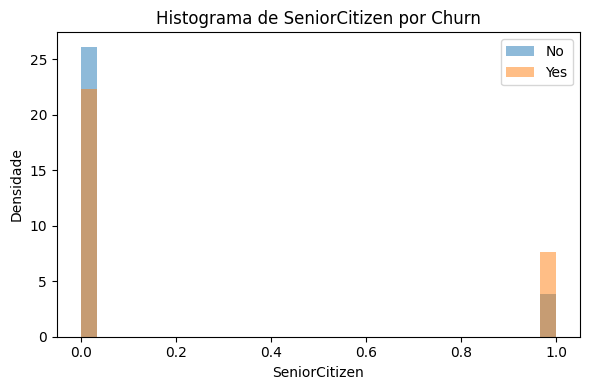

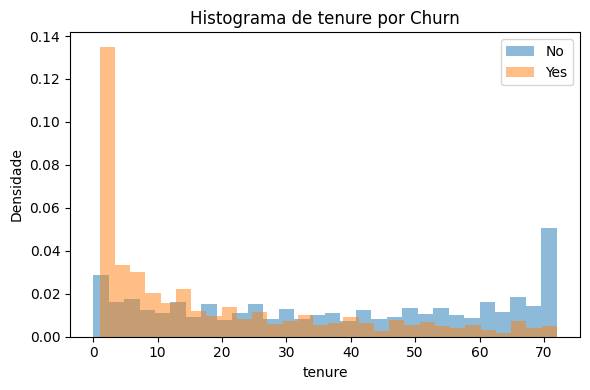

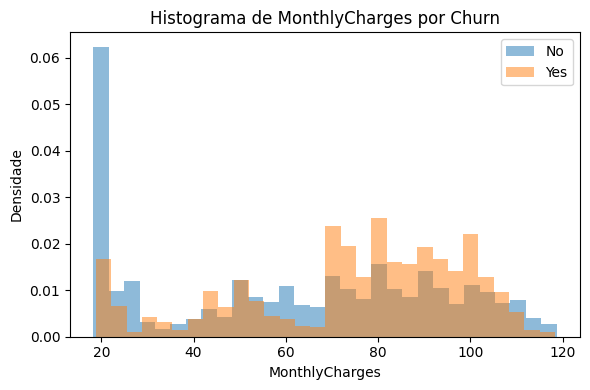

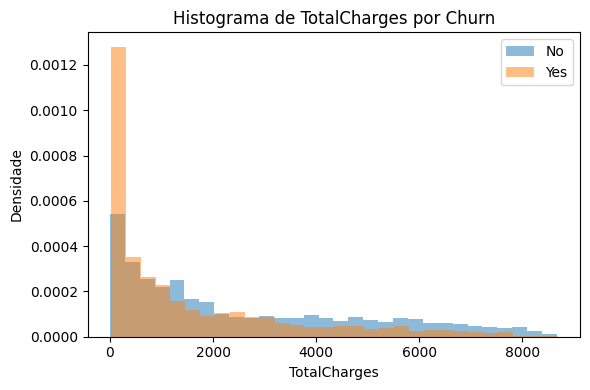

In [709]:
plot_numeric(numeric_vars,'Churn')

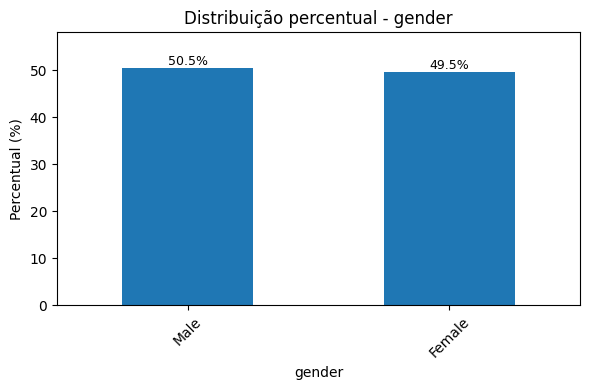

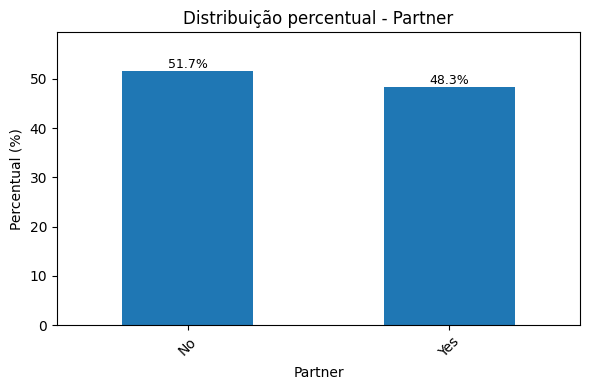

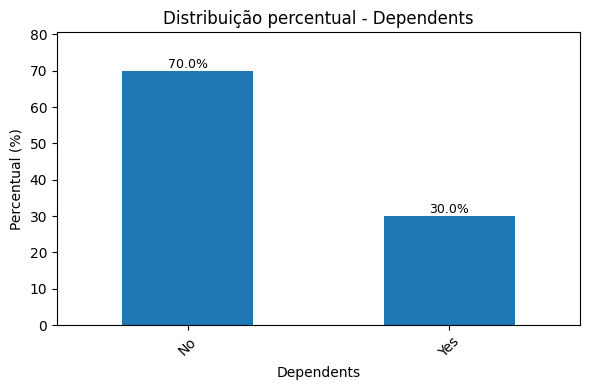

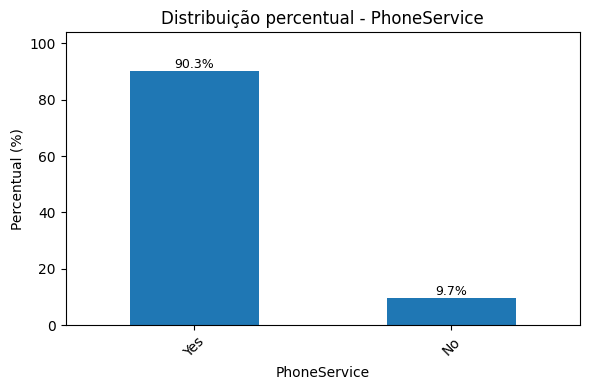

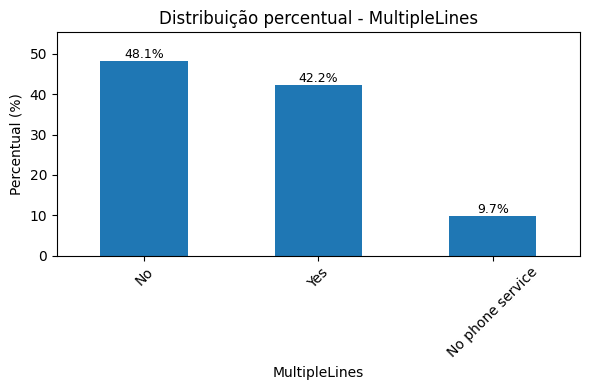

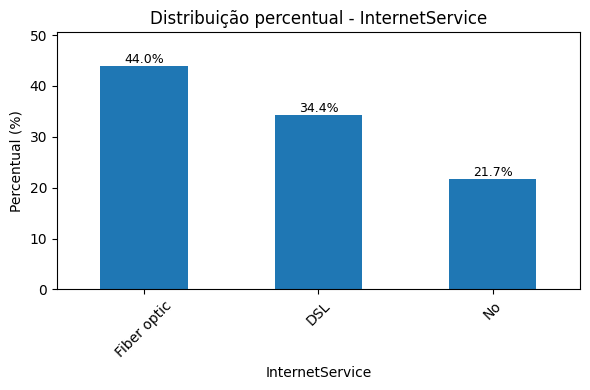

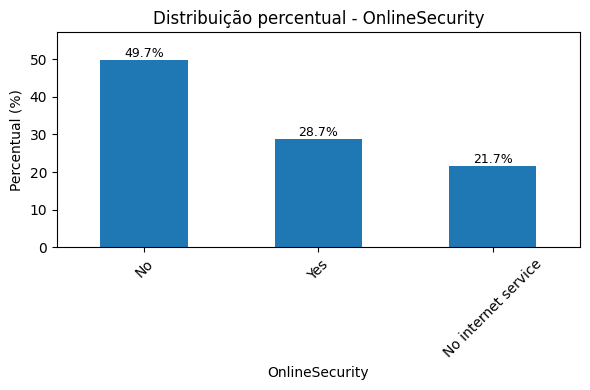

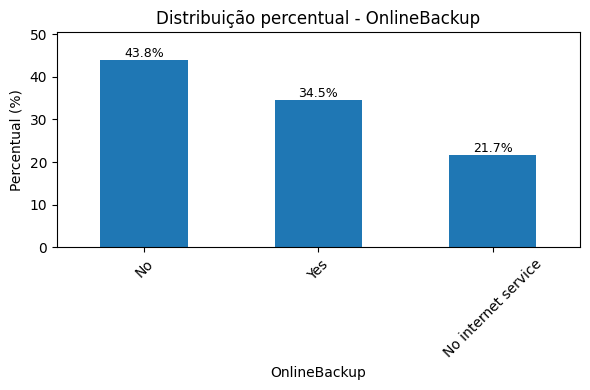

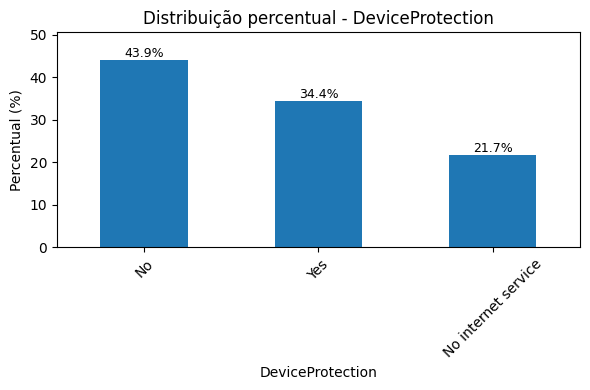

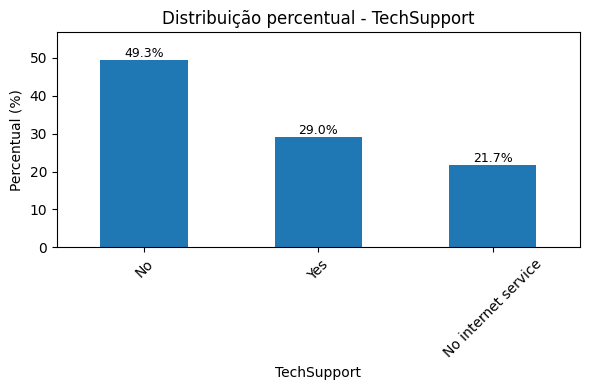

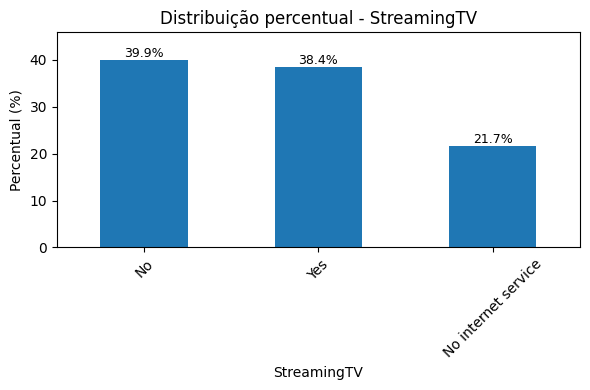

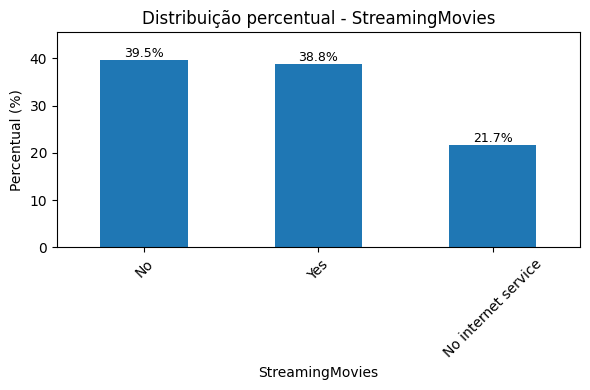

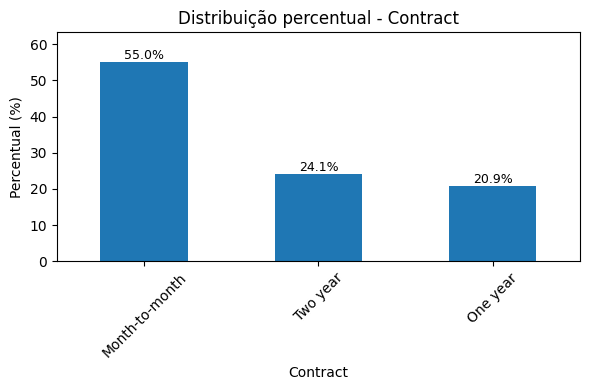

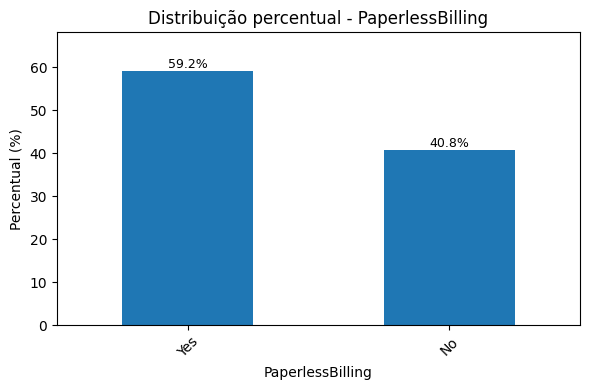

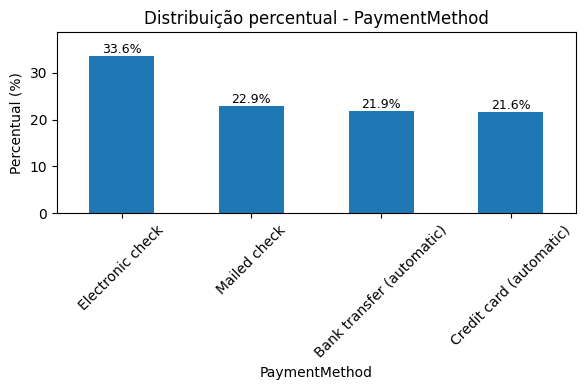

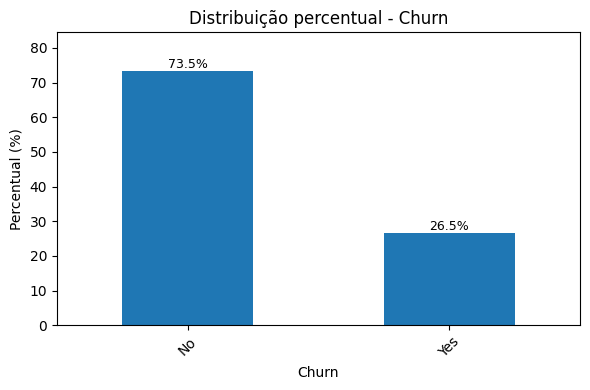

In [710]:
plot_categorical(categorical_vars)

In [739]:
class LogisticRegression:
    def __init__(self, learning_rate=0.1, n_inter=100, threshold=0.5, seed=0):
        self.learning_rate = learning_rate
        self.n_inter = n_inter
        self.threshold=threshold
        self.seed = seed
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        np.random.seed(self.seed)

        X = X.values if hasattr(X, "values") else X
        y = y.values.reshape(-1)

        n_samples, n_features = X.shape

        # Inicialização dos pesos
        self.weights = np.random.rand(n_features)
        self.bias = np.random.rand()

        for _ in range(self.n_inter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = 1 / (1 + np.exp(-linear_model))

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            #print(f"Iter {_}: pesos={self.weights}, bias={self.bias}")
        return self.weights, self.bias
    def predict(self,X):
        # Número de amostras e features
        n_samples, n_features = X.shape

        # Inicialização dos pesos e viés
        #weights = np.random.rand(n_features)
        print('pesos',self.weights)
        #bias = np.random.rand()
        print('bias',self.bias)

         # Combinação linear
        linear_model = np.dot(X, self.weights) + self.bias
        
        # Probabilidades
        y_pred = 1 / (1 + np.exp(-(linear_model)))
        
        # Classificação binária (threshold = 0.5)
        y_pred_class = [1 if i >= self.threshold else 0 for i in y_pred]
        return np.array(y_pred_class),y_pred

### Pre - process

In [726]:
def OrdinalEncoder (base):
    for i in base.select_dtypes(include='object').columns:
        k=0
        lista_dict =[]
        for j in base[i].value_counts().index :
            base.loc[(base[i]==j,i)]=k
            d={j:k}
            k=k+1
            lista_dict .append(d)
            lista_salva=lista_dict
            #print(lista_dic)
        base[i]=base[i].astype('int64')
    return base

def normalization_numeric_colum(base):
    base_2=pd.DataFrame()
    for col in base:
        norm=[ ((x - base[col].mean()) / base[col].std()) for x in base[col]]
        base_2[col]=norm
    return base_2

In [728]:
class MetricasClassificacao:

    def __init__(self, y_true, y_pred, y_score=None):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.y_score = np.array(y_score) if y_score is not None else None

    def _confusion_matrix(self):
        tp = np.sum((self.y_true == 1) & (self.y_pred == 1))
        tn = np.sum((self.y_true == 0) & (self.y_pred == 0))
        fp = np.sum((self.y_true == 0) & (self.y_pred == 1))
        fn = np.sum((self.y_true == 1) & (self.y_pred == 0))
        return tp, tn, fp, fn

    def accuracy(self):
        tp, tn, fp, fn = self._confusion_matrix()
        return (tp + tn) / (tp + tn + fp + fn)

    def precision(self):
        tp, _, fp, _ = self._confusion_matrix()
        return tp / (tp + fp) if (tp + fp) > 0 else 0.0

    def recall(self):
        tp, _, _, fn = self._confusion_matrix()
        return tp / (tp + fn) if (tp + fn) > 0 else 0.0

    def f1_score(self):
        p = self.precision()
        r = self.recall()
        return 2 * p * r / (p + r) if (p + r) > 0 else 0.0

    def roc_curve(self):
        if self.y_score is None:
            raise ValueError("y_score é necessário para calcular a curva ROC.")

        thresholds = np.unique(self.y_score)[::-1]
        tpr_list = []
        fpr_list = []

        for thresh in thresholds:
            y_pred_thresh = (self.y_score >= thresh).astype(int)

            tp = np.sum((self.y_true == 1) & (y_pred_thresh == 1))
            tn = np.sum((self.y_true == 0) & (y_pred_thresh == 0))
            fp = np.sum((self.y_true == 0) & (y_pred_thresh == 1))
            fn = np.sum((self.y_true == 1) & (y_pred_thresh == 0))

            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

            tpr_list.append(tpr)
            fpr_list.append(fpr)

        return np.array(fpr_list), np.array(tpr_list)

    def auc(self, fpr, tpr):
        return np.trapz(tpr, fpr)

    def plot_roc(self):
        fpr, tpr = self.roc_curve()
        roc_auc = self.auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], "--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Curva ROC")
        plt.legend()
        plt.grid(True)
        plt.show()

        return roc_auc

    def resumo(self):
        return {
            "accuracy": self.accuracy(),
            "precision": self.precision(),
            "recall": self.recall(),
            "f1_score": self.f1_score()
        }


In [729]:
#Multicolinearidade test
df_to_model['intercepto'] = 1
df_to_vif=df_to_model.drop("Churn",axis=1)

# Calcular o VIF para cada variável
vif_data = pd.DataFrame()
vif_data["variavel"] = df_to_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_to_vif.values, i) for i in range(df_to_vif.shape[1])]

print(vif_data)

            variavel        VIF
0             gender   1.001607
1            Partner   1.460325
2         Dependents   1.377979
3       PhoneService   3.189715
4      MultipleLines   2.672472
5    InternetService  13.912830
6     OnlineSecurity   3.992972
7       OnlineBackup   3.343085
8   DeviceProtection   3.722234
9        TechSupport   4.254383
10       StreamingTV   3.828508
11   StreamingMovies   3.835762
12          Contract   1.505742
13  PaperlessBilling   1.198091
14     PaymentMethod   1.212696
15     SeniorCitizen   1.147310
16            tenure   6.366279
17    MonthlyCharges  17.334622
18      TotalCharges  10.488538
19        intercepto  15.292209


In [730]:
#Multicolinearidade test
df_to_model['intercepto'] = 1
df_to_vif=df_to_model.drop(["Churn","TotalCharges",'InternetService'],axis=1)

# Calcular o VIF para cada variável
vif_data = pd.DataFrame()
vif_data["variavel"] = df_to_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_to_vif.values, i) for i in range(df_to_vif.shape[1])]

print(vif_data)

            variavel       VIF
0             gender  1.001297
1            Partner  1.460242
2         Dependents  1.374874
3       PhoneService  3.025827
4      MultipleLines  2.634002
5     OnlineSecurity  3.941592
6       OnlineBackup  3.303209
7   DeviceProtection  3.707685
8        TechSupport  4.133679
9        StreamingTV  3.733297
10   StreamingMovies  3.735257
11          Contract  1.478580
12  PaperlessBilling  1.194369
13     PaymentMethod  1.203487
14     SeniorCitizen  1.134676
15            tenure  2.110827
16    MonthlyCharges  3.479949
17        intercepto  9.951502


pesos [-0.01081092 -0.07201379 -0.15886976  0.40713631  0.08032261 -0.4496787
 -0.33973379 -0.04265441  0.04926261 -0.37635125  0.25629579  0.22258148
 -0.43808742 -0.34451083 -0.16760659  0.11024122 -0.99373663  0.3106077
  0.08907238]
bias -0.4420272313679034
{'accuracy': 0.805764588953571, 'precision': 0.662346079066753, 'recall': 0.5468164794007491, 'f1_score': 0.5990621336459555}


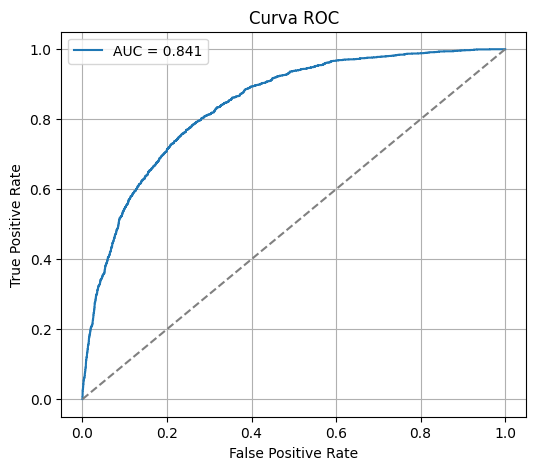

0.8413874533800003

In [ ]:
#First model with all columns
df_to_model=OrdinalEncoder(categorical_vars).join(normalization_numeric_colum(numeric_vars))
colunas=['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod',
       'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
target='Churn'
X_modelo=df_to_model[colunas]
y_modelo=df_to_model[target]


lg=LogisticRegression(n_inter=1000,learning_rate=0.1,seed=0)
weights,bias=lg.fit(X_modelo,y_modelo)
y_pred,y_score=lg.predict(X_modelo)

metricas = MetricasClassificacao(y_modelo, y_pred, y_score)

print(metricas.resumo())
metricas.plot_roc()

pesos [-0.02613592 -0.07755695 -0.18043076  0.30187966  0.08058084 -0.38762586
 -0.11736286  0.0098581  -0.37010268  0.16464959  0.23754497 -0.46751956
 -0.41362287 -0.1867145   0.1175788  -0.8918862   0.52638985]
bias -0.48841162145405614
{'accuracy': 0.8034928297600454, 'precision': 0.6531901452937461, 'recall': 0.5532370251471375, 'f1_score': 0.5990730011587485}


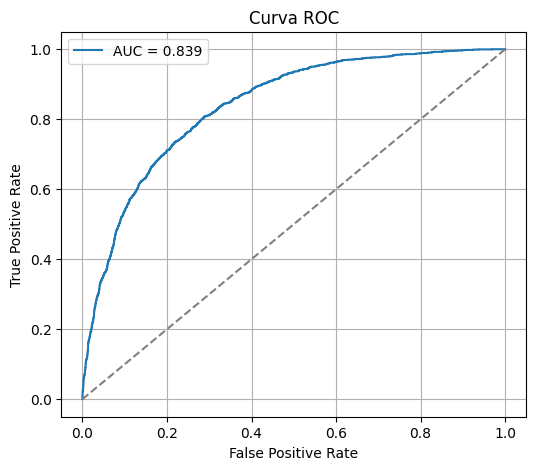

0.8389721480597208

In [741]:
#Model without columns which VIF>10
df_to_model=OrdinalEncoder(categorical_vars).join(normalization_numeric_colum(numeric_vars))
colunas=vif_data.loc[(vif_data['variavel']!='intercepto','variavel')].values
target='Churn'
X_modelo=df_to_model[colunas]
y_modelo=df_to_model[target]


lg2=LogisticRegression(n_inter=1000,learning_rate=0.1,seed=0)
weights,bias=lg2.fit(X_modelo,y_modelo)
y_pred2,y_score2=lg2.predict(X_modelo)

metricas2 = MetricasClassificacao(y_modelo, y_pred2, y_score2)

print(metricas2.resumo())
metricas2.plot_roc()

In [ ]:
#Model without columns which VIF>10 and check all threshold
df_to_model=OrdinalEncoder(categorical_vars).join(normalization_numeric_colum(numeric_vars))
colunas=vif_data.loc[(vif_data['variavel']!='intercepto','variavel')].values
target='Churn'
X_modelo=df_to_model[colunas]
y_modelo=df_to_model[target]

model=LogisticRegression(n_inter=1000,learning_rate=0.01,seed=0)
weights,bias=model.fit(X_modelo,y_modelo)
y_pred_model,y_score_model=model.predict(X_modelo)

df_metricas=pd.DataFrame(columns=['accuracy','precision','recall','f1_score'])
accuracy_list=[]
precision_list=[]
recall_list=[]
f_score_list=[]
th=np.arange(0.1,1,0.05)
for  i in th:
    print(f'threshold {i}')
    y_pred_model2= [1 if j >= i else 0 for j in y_score_model]
    metricas_model = MetricasClassificacao(y_modelo, y_pred_model2, y_score_model)
    accuracy_list.append(metricas_model.resumo()['accuracy'])
    precision_list.append(metricas_model.resumo()['precision'])
    recall_list.append(metricas_model.resumo()['recall'])
    f_score_list.append(metricas_model.resumo()['f1_score'])
    print(metricas_model.resumo())


pesos [ 0.08025209  0.0694566   0.12307742  0.40617369 -0.11651028 -0.27951644
 -0.3691381   0.02158408 -0.00252816 -0.27992165  0.05310196 -0.44560097
 -0.03182721 -0.34684417  0.18153249 -0.51232785  0.32787548]
bias -0.057890799633435984
threshold 0.1
{'accuracy': 0.5476359505892375, 'precision': 0.3641988038770881, 'recall': 0.9448903156768326, 'f1_score': 0.5257517118189937}
threshold 0.15000000000000002
{'accuracy': 0.6379383785318756, 'precision': 0.41373194831517607, 'recall': 0.8737292669876939, 'f1_score': 0.561554332874828}
threshold 0.20000000000000004
{'accuracy': 0.6862132613942922, 'precision': 0.4511321295500143, 'recall': 0.8421615837346175, 'f1_score': 0.5875326614408362}
threshold 0.25000000000000006
{'accuracy': 0.7167400255572909, 'precision': 0.4798206278026906, 'recall': 0.8014981273408239, 'f1_score': 0.6002805049088359}
threshold 0.30000000000000004
{'accuracy': 0.7390316626437597, 'precision': 0.5055140519388118, 'recall': 0.7602996254681648, 'f1_score': 0.607

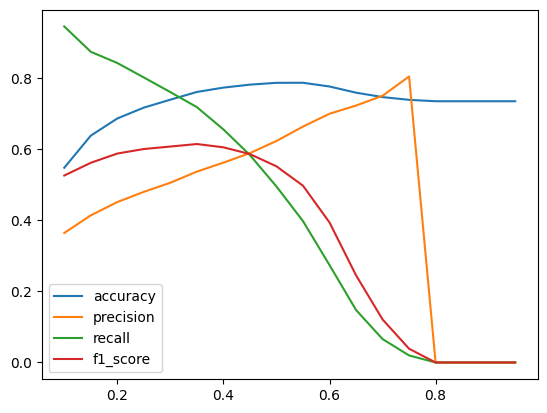

In [768]:
plt.plot(pd.DataFrame(index=th,data=accuracy_list),label='accuracy')
plt.plot(pd.DataFrame(index=th,data=precision_list),label='precision')
plt.plot(pd.DataFrame(index=th,data=recall_list),label='recall')
plt.plot(pd.DataFrame(index=th,data=f_score_list),label='f1_score')
plt.legend()